<!--Header-->
<div style="background-color: #fff; color: black">
<div style="padding-bottom: 20px; display: flex; justify-content: space-between; align-items: flex-start;">
<div style="width: 60%;">
<h1 style="margin: 16px">TFG - Inteligencia Artificial</h1>
<p style="margin: 16px; padding-bottom: 0">Junio de 2025</p>
</div>
<div style="width: 40%; text-align: right">
<img src="https://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" alt="Logo UOC">
</div>
</div>
<h2 style="text-align: justify; padding: 0 16px">Aplicación de técnicas de IA fiable en la predicción del índice de calidad de vida en personas con tratamiento oncológico mediante aprendizaje automático.</h2>
<div style="background-color: #000; width: 100%; height: 2px; margin: 24px 0"></div>
<div style="padding: 20px">
<h4 style="margin: 0 0; padding: 0 0">Pablo Pimàs Verge</h4>
<h5 style="margin: 0 0; padding: 0 0">Grado en Ingeniería Informática</h5>
<h5 style="margin: 0 0 4px; padding: 0 0">Inteligencia Artificial</h5>
<h4 style="margin: 8px 0 4px; padding: 0 0">Dra. María Moreno de Castro</h4>
<h4 style="margin: 0 0; padding: 0 0">Dr. Friman Sanchéz</h4>
</div>
</div>

# Fase 3

## Cuantificación de la incertidumbre del modelo

Una vez realizada la clasificación y explicado el comportamiento del modelo, abordamos la cuantificación de la incertidumbre de nuestro modelo final; es decir, analizamos cómo estimar de forma fiable el grado de confianza en cada predicción. Para ello aplicaremos técnicas de Predicción Conforme (Conformal Prediction) y, en concreto, el método Venn–ABERS, que nos permite generar intervalos de confianza adaptativos y probabilidades calibradas. A lo largo del notebook veremos cómo ajustar el calibrador sobre un conjunto reservado, cómo evaluar la calidad de la calibración (p. ej. con reliability diagrams) y, finalmente, cómo interpretar los intervalos de predicción resultantes para apoyar la toma de decisiones clínicas con un nivel de certeza cuantificado.

Este cuaderno corresponde a la fase 3 del plan de trabajo del TFG. Se aborda la cuantificación de la incertidumbre del modelo seleccionado en el cuaderno de clasificación binaria [2] y finaliza el ciclo establecido por la metodología CRISP-DM.

### Objetivos

El objetivo de este cuaderno es proporcionar es calibrar y cuantificar la incertidumbre de las predicciones del modelo final mediante Predicción Conforme Venn–ABERS, produciendo probabilidades ajustadas e intervalos de confianza para cada paciente.

### Estrategia

Se ha seguido una estrategia modular que combina calibración y evaluación de la fiabilidad de las probabilidades predichas:

1.	Partición dedicada para calibración
Tras reservar un subconjunto (10 %) exclusivamente para calibración (sin usar en entrenamiento ni validación del umbral), dividimos los datos en bloques de entrenamiento, prueba y calibración.

2.  Empleamos Predicción Conforme Venn–ABERS sobre el modelo entrenado para aprender a convertir las puntuaciones crudas en probabilidades calibradas.

3.  Aplicamos el esquema Venn–ABERS al conjunto de prueba para obtener, para cada muestra, un par de límites de probabilidad p_low, p_high y una probabilidad puntual ajustada.

4.  Evaluación de la calibración

    - Curva de confiabilidad (reliability diagram): comparamos las probabilidades predichas con las frecuencias observadas en bins iguales.
    - Error de calibración esperado (ECE) y Brier score: cuantificamos la desviación promedio entre predicción y realidad.
    

5.	Calculamos la anchura media de los intervalos y la cobertura (porcentaje de veces que la etiqueta verdadera cae dentro de p_low, p_high) para evaluar el compromiso entre confianza y precisión.

6.  Identificamos las muestras con intervalos más amplios o con mayor incertidumbre, examinándolas con técnicas de explicabilidad para entender qué características generan vacilación en el modelo.

Con esta hoja de ruta garantizamos una cuantificación rigurosa de la incertidumbre: calibramos las salidas para que reflejen fielmente la probabilidad real, evaluamos su calidad estadística y analizamos en qué escenarios el modelo muestra menos certeza.

### Índice

1. Calibración

### Importaciones y Configuraciones

In [1]:
# Code carbon
from codecarbon import EmissionsTracker
tracker = EmissionsTracker(
    project_name="TFG-IA-UQ",    
    output_dir="../carbon",
)
tracker.start()

[codecarbon WARNING @ 19:04:50] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 19:04:50] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon INFO @ 19:04:50] [setup] RAM Tracking...
[codecarbon INFO @ 19:04:50] [setup] CPU Tracking...
[codecarbon WARNING @ 19:04:50] We saw that you have a Apple M2 Pro but we don't know it. Please contact us.
[codecarbon WARNING @ 19:04:50] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 19:04:50] CPU Model on constant consumption mode: Apple M2 Pro
[codecarbon WARNING @ 19:04:50] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 19:04:50] [setup] GPU Tracking...
[codecarbon INFO @ 19:04:50] No GPU found.
[codecarbon INFO @ 19:04:50] The below tracking methods have been set up:
    

In [2]:
# Importaciones de librerías básicas
import joblib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

# Importaciones de Scikit-learn 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.model_selection import FixedThresholdClassifier

# Librerías UQ
import ptocca_ivap as ivap

# Librerías XAI
import shap
import dice_ml as dice

# Funciones auxiliares
import xaiuq_functions as afn

In [3]:
%matplotlib inline
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format
plt.rc('font', size=10)
plt.rcParams["legend.frameon"] = False
sns.set_theme(
    style="white",
    palette="viridis",
    rc={
        "axes.spines.left": False,
        "axes.spines.bottom": False,
        "axes.spines.right": False,
        "axes.spines.top": False
    }
)
figsize = (12,4)
palette= sns.color_palette("viridis", 30)
sns.set_style("white", {"axes.grid": False})

### Carga de datos

Cargamos los conjuntos de datos que se han generado en la fase de modelado para la clasificación binaria. 

In [4]:
# Importamos todos los conjuntos generados en la fase de modelado
X_train = pd.read_csv('../Fase 2/data/QLQ_C30_C23_X_train.csv')
X_test = pd.read_csv('../Fase 2/data/QLQ_C30_C23_X_test.csv')
X_cal = pd.read_csv('../Fase 2/data/QLQ_C30_C23_X_cal.csv')
y_train = pd.read_csv('../Fase 2/data/QLQ_C30_C23_y_train.csv').squeeze()
y_test = pd.read_csv('../Fase 2/data/QLQ_C30_C23_y_test.csv').squeeze()
y_cal = pd.read_csv('../Fase 2/data/QLQ_C30_C23_y_cal.csv').squeeze()

### Carga del modelo seleccionado

Se carga el modelo final entrenado durante la fase de clasificación binaria. El modelo ha sido previamente almacenado en un archivo serializado (best_bundle.pkl), que incluye tanto el clasificador como el umbral de decisión óptimo identificado durante el ajuste final.

Luego, se utiliza la clase FixedThresholdClassifier para crear una instancia del modelo que aplica el umbral personalizado directamente sobre las puntuaciones crudas predichas (predict_proba). De esta forma, se garantiza que todas las explicaciones posteriores reflejen fielmente el comportamiento real del clasificador tal y como fue evaluado, sin depender del umbral por defecto.

In [5]:
# Cargamos el paquete con el modelo seleccionado y su umbral de decisión
# Fijamos el modelo con el umbral y llamamos al metodo fit para que se almacene el self.estimator_
bundle = joblib.load('../Fase 2/models/best_bundle.pkl')
model = bundle['model']
threshold = bundle['threshold']
model_th = FixedThresholdClassifier(model, threshold=threshold, response_method='predict_proba').fit(X_train, y_train)

## 1. Calibración

La calibración de un clasificador consiste en ajustar sus salidas —las puntuaciones o “probabilidades heurísticas” que devuelve predict_proba— de modo que se correspondan con probabilidades reales. En un modelo no calibrado, un valor de 0.8 puede significar que, en promedio, sólo el 60 % de las instancias asignadas a esa puntuación pertenecen realmente a la clase positiva. Para aplicaciones clínicas, donde se quiere apoyar decisiones de intervención basadas en un umbral de riesgo, es fundamental que esas probabilidades reflejen la frecuencia observada de casos positivos.

En primer lugar, obtenemos las predicciones y las probabilidades heurísticas del modelo, para los conjuntos de calibración y prueba. 

In [6]:
# Predicciones del conjunto de prueba
y_pred_test = model_th.predict(X_test)
y_pred_cal = model_th.predict(X_cal)
# Probabilidades heurísticas de la clase «mejorable»
y_h_prob_test = model.predict_proba(X_test)[:, 1]
y_h_prob_cal = model.predict_proba(X_cal)[:, 1]

Vamos a visualizar la distribución de las probabilidades heurísticas (raw scores) para el conjunto de prueba para valorar hasta qué punto el modelo está entregando salidas cercanas a 0 o a 1 —es decir, con cuánta confianza toma sus decisiones— frente a cuántas probabilidades quedan en la zona intermedia, donde el modelo es más incierto. Esa información es clave  porque una buena calibración busca alinear esos scores con las frecuencias reales de ocurrencia: si el modelo asigna una probabilidad del 0.7 a 100 casos, idealmente deberíamos observar que unos 70 de ellos realmente pertenecen a la clase positiva. 

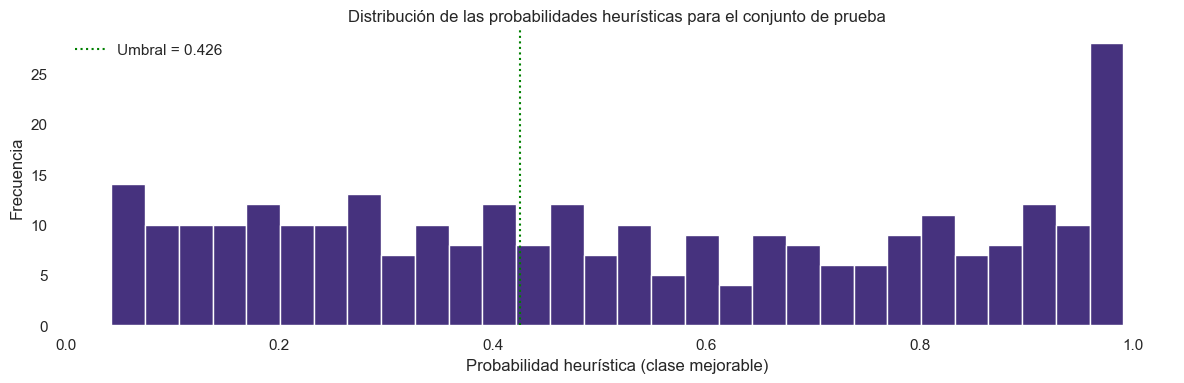

In [7]:
# Visualizamos la distribución para el set de prueba 
plt.figure(figsize=figsize)
plt.hist(y_h_prob_test, bins=30)
plt.axvline(threshold, color='green', linestyle=':', linewidth=1.5, label=f"Umbral = {round(threshold, 3)}")
plt.title("Distribución de las probabilidades heurísticas para el conjunto de prueba")
plt.xlabel("Probabilidad heurística (clase mejorable)")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
sns.despine(bottom=True, left=True)
plt.show()

En el histograma se aprecian tres zonas con frecuencias especialmente altas: valores muy próximos a 0 (predicciones muy seguras de la clase ‘aceptable’), alrededor del umbral ∼0.43, y valores muy próximos a 1 (predicciones muy seguras de la clase ‘mejorable’). Entre el umbral y valores intermedios (∼0.5-0.8) las frecuencias disminuyen, lo que indica que el modelo es menos proclive a asignar puntuaciones moderadas y, por tanto, se muestra menos confiado en esa región.

Profundizamos el análisis visualizando la distribución acumulada de las puntuaciones

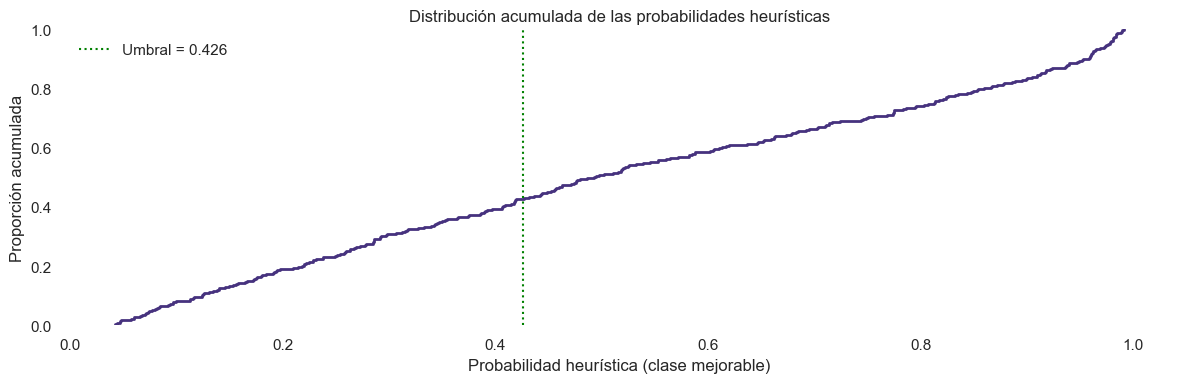

In [8]:
# Visualización de la distribución acumulada de las puntuaciones crudas
plt.figure(figsize=figsize)
sns.ecdfplot(x=y_h_prob_test, stat='proportion', linewidth=2)
plt.axvline(threshold, color='green', linestyle=':', linewidth=1.5,
            label=f"Umbral = {threshold:.3f}")
plt.title("Distribución acumulada de las probabilidades heurísticas")
plt.xlabel("Probabilidad heurística (clase mejorable)")
plt.ylabel("Proporción acumulada")
plt.legend()
plt.tight_layout()
sns.despine(bottom=True, left=True)
plt.show()

La curva acumulada muestra, para cada valor de probabilidad heurística en el eje horizontal, qué proporción del conjunto de prueba tiene un score igual o inferior a ese valor. Por ejemplo, en el umbral óptimo (~0,426) la curva alcanza aproximadamente el 0.42, lo que significa que un 42 % de las instancias reciben una probabilidad menor o igual a 0,426 (se etiquetan como «aceptables»), mientras que el 58 % restante supera ese umbral y se clasifica como «mejorable». La forma relativamente lineal de la curva indica que los scores están bastante repartidos a lo largo de todo el rango, sin concentraciones exageradas en un solo extremo, lo cual refuerza la necesidad de ajustar con cuidado el umbral para controlar el equilibrio entre falsos positivos y falsos negativos.

### Cobertura 

Calcularemos el “coverage” para distintos umbrales, entendiendo cada raw score τ como si implicara un τ·100 % de aciertos. De este modo tendremos un punto de partida claro sobre la confiabilidad bruta de nuestro Random Forest antes de calibrarlo.

Para cada nivel de confianza t (0.0, 0.05, 0.10, …, 1.0), tomamos todas las muestras cuya probabilidad predicha de la clase positiva (y_h_prob_test) sea ≥ t y calculamos la fracción de verdaderos positivos entre ese subgrupo:
$$\mathrm{coverage}(t)
\;=\;
P\bigl(Y=1 \mid \hat p \ge t\bigr)
\;=\;
\frac{\#\{\,i : \hat p_i \ge t \text{ y } y_i=1\}}
{\#\{\,i : \hat p_i \ge t\}}$$
Esta es la reliability curve o diagrama de confiabilidad: a “alta probabilidad predicha” debería corresponder “alta frecuencia de resultados positivos”.

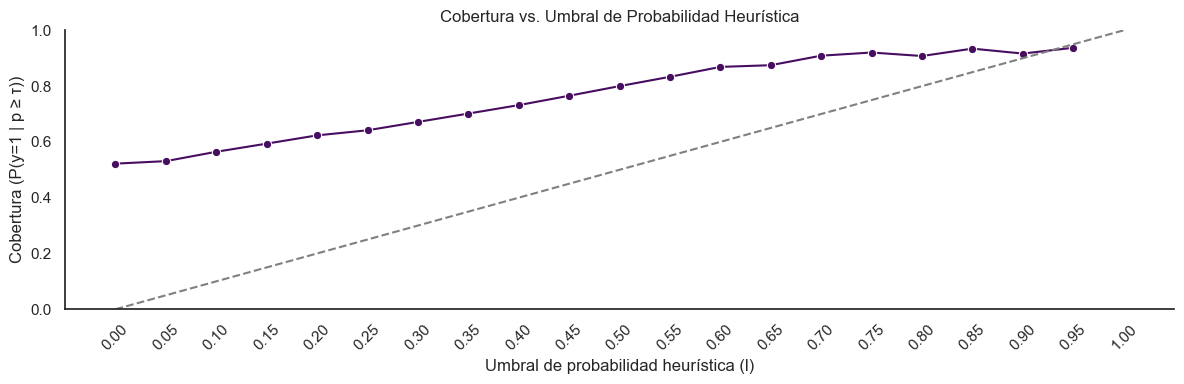

In [11]:
thresholds = np.linspace(0, 1, 21)
coverages = []

# Para cada umbral calculamos el coverage: P(Y=1 | p >= threshold)
for t in thresholds:
    mask = y_h_prob_test >= t
    if mask.sum() > 0:
        coverages.append(np.mean(y_test[mask] == 1))
    else:
        coverages.append(np.nan)
# Dibujamos la curva
plt.figure(figsize=figsize)
sns.lineplot(x=thresholds, y=coverages, marker='o', color=palette[0])
plt.plot(thresholds, thresholds, linestyle='--', color='gray', label='Coverage = l')
plt.title("Cobertura vs. Umbral de Probabilidad Heurística")
plt.xlabel("Umbral de probabilidad heurística (l)")
plt.ylabel("Cobertura (P(y=1 | p ≥ τ))")
plt.ylim(0, 1)
plt.xticks(thresholds, rotation=45)
plt.tight_layout()
sns.despine()
plt.show()

### Alineación de las probabilidades heurísticas con la calibración ideal

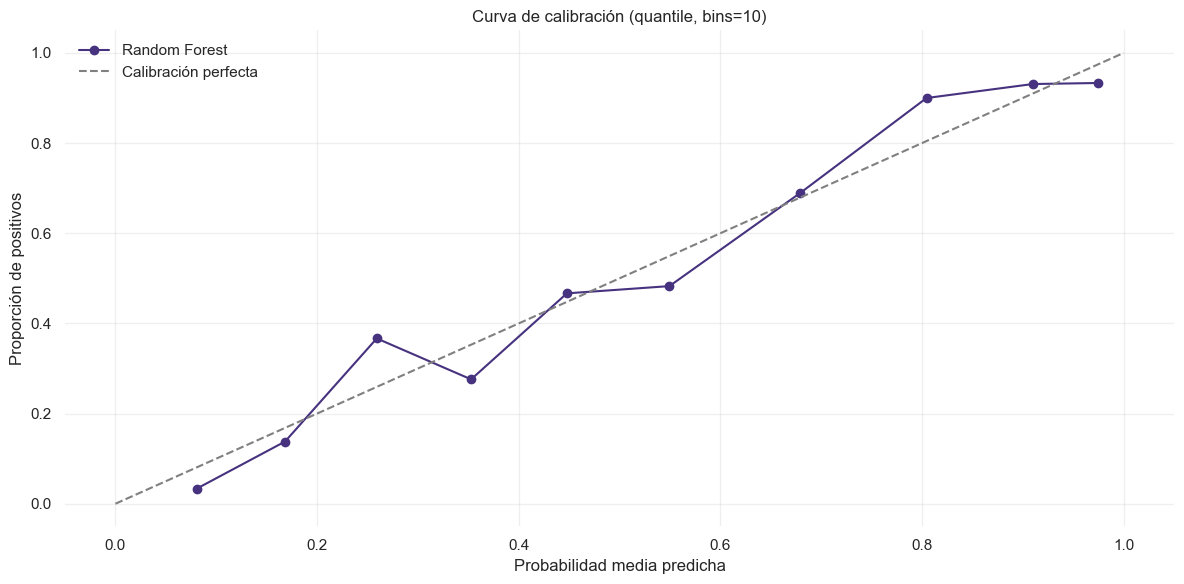

In [12]:
# Visualizamos la alineación de las probabilidades heurísticas asignadas por el modelo con respecto a la calibración perfecta
h_probs = [
    (y_h_prob_test, "Random Forest"),
]
afn.viz_calibration_curve(h_probs, y_test, n_bins=10, strategy='quantile')

### Métricas

In [13]:
models_metrics = [('Random Forest', y_pred_test, y_h_prob_test)]
afn.compute_metrics(models_metrics, y_test)

,Accuracy,F1-score,Recall,Precision,ROC AUC,Brier Score,Log loss
Model,,,,,,,
Random Forest,0.77,0.79,0.83,0.76,0.85,0.15,0.47


## 1.1 Platt Scaling e Isotonic Regression

In [14]:
model_iso = CalibratedClassifierCV(model, cv=5, method="isotonic")
model_platt = CalibratedClassifierCV(model, cv=5, method="sigmoid")

model_iso.fit(X_train, y_train)
model_platt.fit(X_train, y_train)

y_pred_isotonic = model_iso.predict(X_test)
y_pred_platt = model_platt.predict(X_test)

y_h_prob_isotonic = model_iso.predict_proba(X_test)[:,1]
y_h_prob_platt = model_platt.predict_proba(X_test)[:,1]

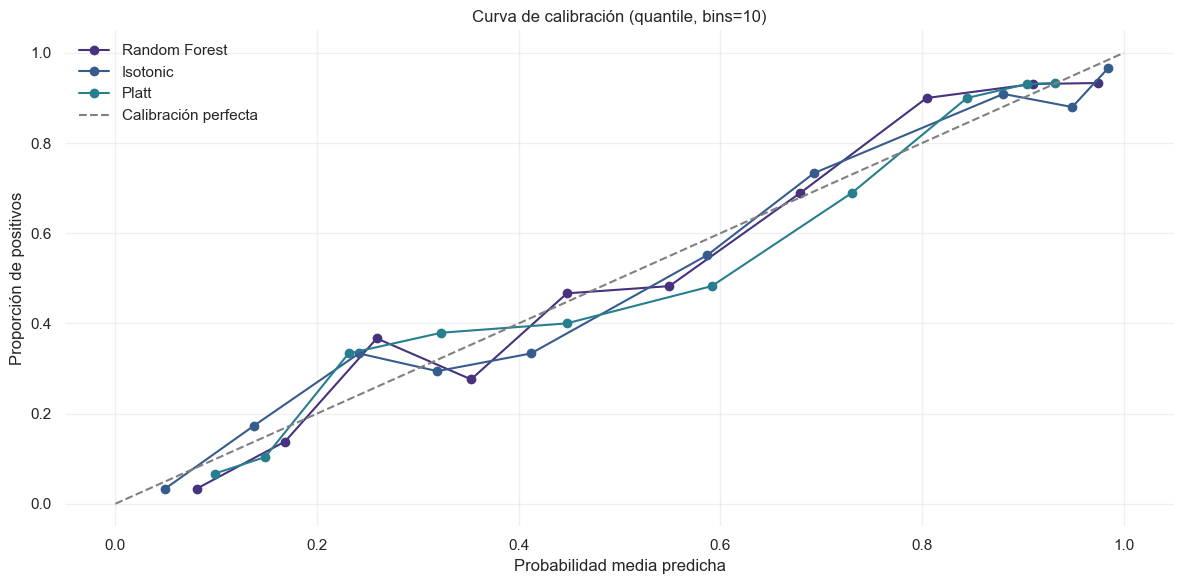

In [15]:
h_probs = [
    (y_h_prob_test, "Random Forest"),
    (y_h_prob_isotonic, "Isotonic"),
    (y_h_prob_platt, "Platt"),
]
afn.viz_calibration_curve(h_probs, y_test, n_bins=10, strategy='quantile')

In [16]:
models_metrics.extend([
    ('RF + Platt Scaling', y_pred_platt,   y_h_prob_platt),
    ('RF + Isotonic Reg.', y_pred_isotonic, y_h_prob_isotonic)
])
afn.compute_metrics(models_metrics, y_test)

,Accuracy,F1-score,Recall,Precision,ROC AUC,Brier Score,Log loss
Model,,,,,,,
Random Forest,0.77,0.79,0.83,0.76,0.85,0.15,0.47
RF + Platt Scaling,0.76,0.77,0.76,0.78,0.86,0.15,0.47
RF + Isotonic Reg.,0.79,0.79,0.77,0.81,0.86,0.15,0.48


## 1.2 Venn-ABERS

In [17]:
y_h_prob_cal = model.predict_proba(X_cal.to_numpy())[:,1]
calibrated_points = list(zip(y_h_prob_cal.tolist(), y_cal.to_numpy().tolist()))
y_h_prob_test = model.predict_proba(X_test.to_numpy())[:,1]
p0, p1 = ivap.ScoresToMultiProbs(calibrated_points, y_h_prob_test.tolist())

In [18]:
h_prob_va_df = pd.DataFrame({
    'h_prob':    y_h_prob_test,
    'p_ivap':    p1 / (1 - p0 + p1),
    'p0':        p0,
    'p1':        p1,
    'interval_width': p1 - p0,
    'p_mid':     0.5 * (p0 + p1),
    'QoL':       y_test.to_numpy(),
})
h_prob_va_df['y_pred_va']        = (h_prob_va_df['p_ivap'] >= threshold).astype(int)
h_prob_va_df['predicted_label']  = (h_prob_va_df['h_prob'] >= threshold).astype(int)
h_prob_va_df.nlargest(10, 'interval_width')

,h_prob,p_ivap,p0,p1,interval_width,p_mid,QoL,y_pred_va,predicted_label
44,0.62,0.67,0.59,0.83,0.24,0.71,1.00,1,1
160,0.34,0.51,0.40,0.62,0.22,0.51,0.00,1,0
90,0.33,0.50,0.39,0.62,0.22,0.50,0.00,1,0
252,0.33,0.51,0.40,0.62,0.22,0.51,0.00,1,0
56,0.31,0.49,0.38,0.60,0.22,0.49,0.00,1,0
58,0.15,0.18,-0.00,0.21,0.21,0.11,0.00,0,0
95,0.15,0.18,-0.00,0.21,0.21,0.11,0.00,0,0
21,0.32,0.50,0.39,0.60,0.21,0.50,1.00,1,0
31,0.32,0.50,0.39,0.60,0.21,0.50,0.00,1,0
99,0.31,0.50,0.39,0.60,0.21,0.50,1.00,1,0


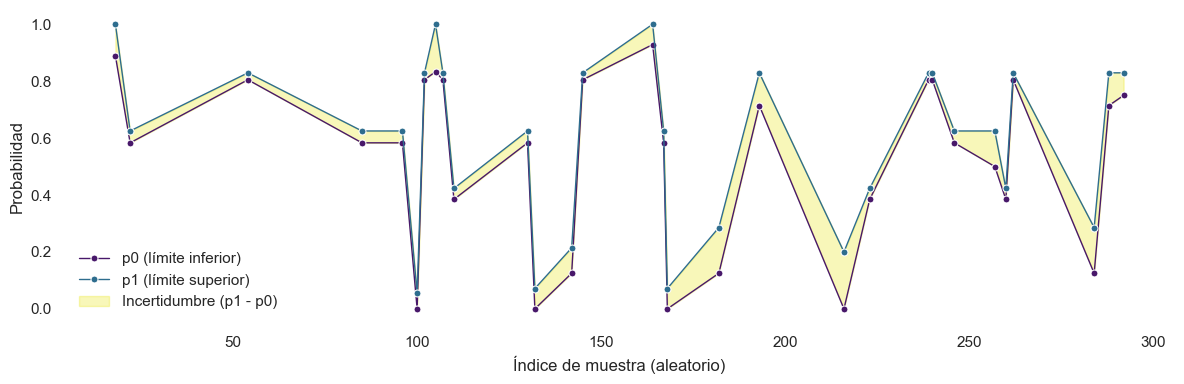

In [19]:
random30 = h_prob_va_df.sample(n=30).sort_index()

plt.figure(figsize=figsize)
sns.lineplot(x=random30.index, y=random30["p0"], color=palette[1], marker="o", markersize=5, lw=1, label="p0 (límite inferior)")
sns.lineplot(x=random30.index, y=random30["p1"], color=palette[10], marker="o", markersize=5, lw=1, label="p1 (límite superior)")
# rellenamos la banda de incertidumbre
plt.fill_between(
    random30.index,
    random30["p0"],
    random30["p1"],
    alpha=0.3,
    color=palette[29],
    label="Incertidumbre (p1 - p0)"
)
plt.xlabel("Índice de muestra (aleatorio)")
plt.ylabel("Probabilidad")
plt.legend()
plt.tight_layout()
sns.despine(bottom=True, left=True)
plt.show()


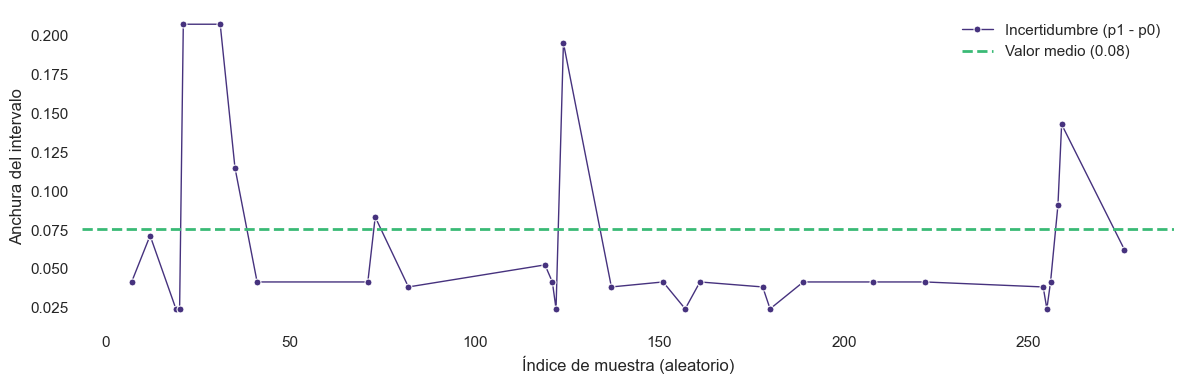

In [20]:
# tomamos 30 muestras al azar, ordenadas por índice para que no estén mezcladas
sample = h_prob_va_df['interval_width'].sample(n=30).sort_index()

# calcular valor medio
interval_mean = h_prob_va_df['interval_width'].mean()

plt.figure(figsize=figsize)
sns.lineplot(
    x=sample.index,
    y=sample.values,
    marker="o",
    markersize=5,
    linewidth=1,
    label="Incertidumbre (p1 - p0)"
)

plt.axhline(
    interval_mean,
    linestyle="--",
    linewidth=2,
    color=palette[20],
    label=f"Valor medio ({interval_mean:.2f})"
)

plt.xlabel("Índice de muestra (aleatorio)")
plt.ylabel("Anchura del intervalo")
plt.legend()
plt.tight_layout()
sns.despine(bottom=True, left=True)
plt.show()

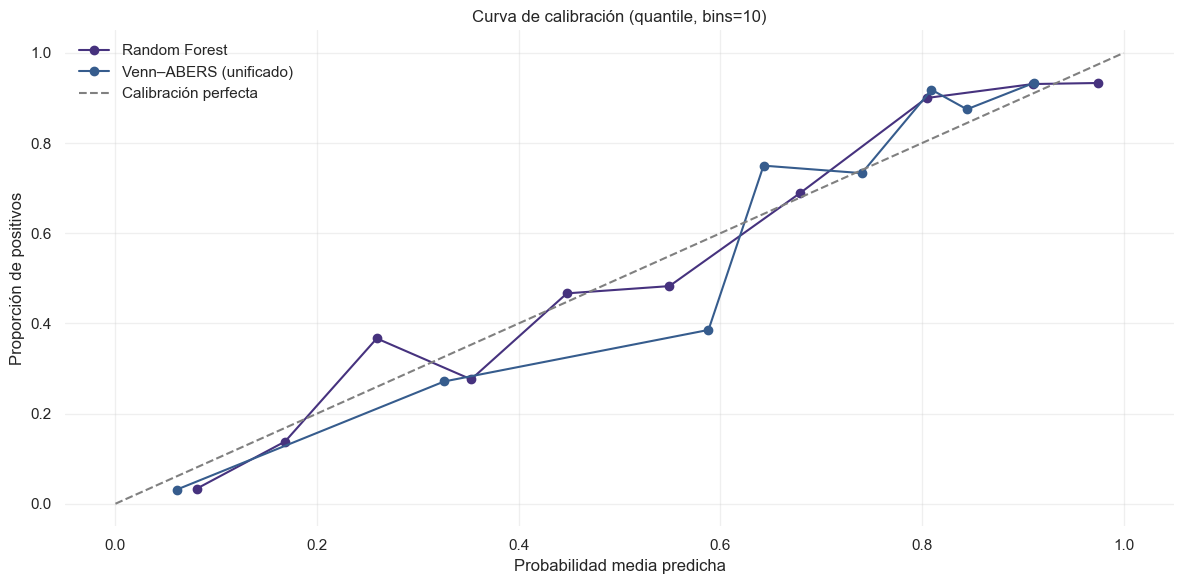

In [21]:
h_probs_va = [
    (h_prob_va_df['h_prob'], 'Random Forest'),
    (h_prob_va_df['p_ivap'], 'Venn–ABERS (unificado)')
]
afn.viz_calibration_curve(h_probs_va, y_test, n_bins=10, strategy='quantile')

In [22]:
models_metrics.extend([
    ('RF + IVAP', h_prob_va_df['y_pred_va'],   h_prob_va_df['p_ivap']),
])
afn.compute_metrics(models_metrics, y_test)

,Accuracy,F1-score,Recall,Precision,ROC AUC,Brier Score,Log loss
Model,,,,,,,
Random Forest,0.77,0.79,0.83,0.76,0.85,0.15,0.47
RF + Platt Scaling,0.76,0.77,0.76,0.78,0.86,0.15,0.47
RF + Isotonic Reg.,0.79,0.79,0.77,0.81,0.86,0.15,0.48
RF + IVAP,0.71,0.77,0.89,0.67,0.85,0.17,0.49


## Intervalos de incertidumbre

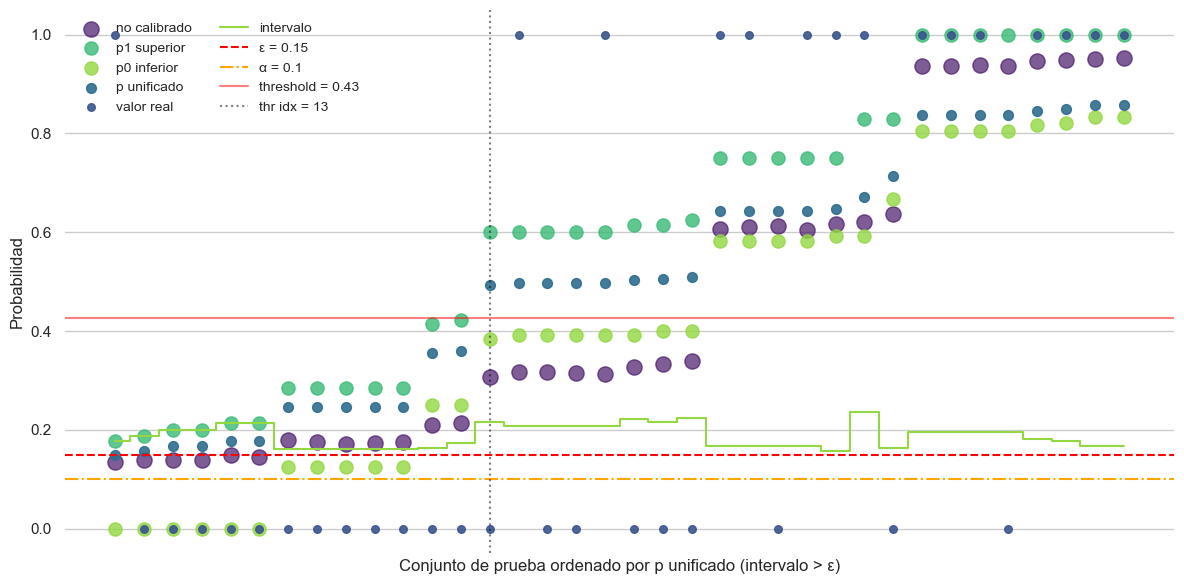

In [23]:
# mostrar solo las predicciones cuyo intervalo conformal tenga una anchura mayor al 10 % (0.10).
afn.conformal_probabilities(threshold, h_prob_va_df)

## 2. Explicabilidad

In [24]:
mejorables = h_prob_va_df[h_prob_va_df['QoL'] == 1]
# TP seguro (menor incertidumbre entre los positivos correctamente clasificados)
tp_high = mejorables.loc[(mejorables['predicted_label'] == 1)].loc[lambda df: df['interval_width'].idxmin()]
# TP inseguro (mayor incertidumbre entre los positivos correctamente clasificados)
tp_low = mejorables.loc[(mejorables['predicted_label'] == 1)].loc[lambda df: df['interval_width'].idxmax()]
# FN seguro (menor incertidumbre entre los falsos negativos)
fn_high = mejorables.loc[(mejorables['predicted_label'] == 0)].loc[lambda df: df['interval_width'].idxmin()]
# FN inseguro (mayor incertidumbre entre los falsos negativos)
fn_low = mejorables.loc[(mejorables['predicted_label'] == 0)].loc[lambda df: df['interval_width'].idxmax()]

In [25]:
fn_low

h_prob            0.32
p_ivap            0.50
p0                0.39
p1                0.60
interval_width    0.21
p_mid             0.50
QoL               1.00
y_pred_va         1.00
predicted_label   0.00
Name: 21, dtype: float64

In [26]:
explainer = shap.TreeExplainer(model)
shap.initjs()

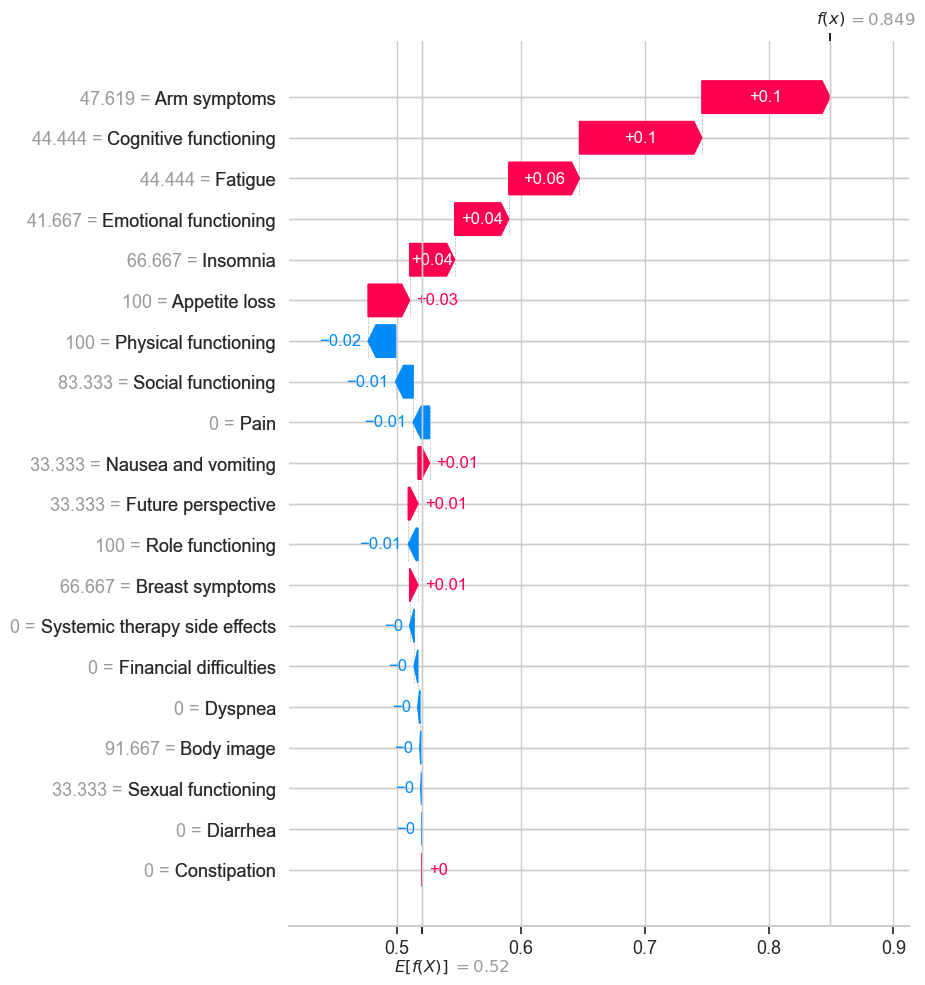

In [27]:
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[:,:,1][tp_high.name], max_display=20)

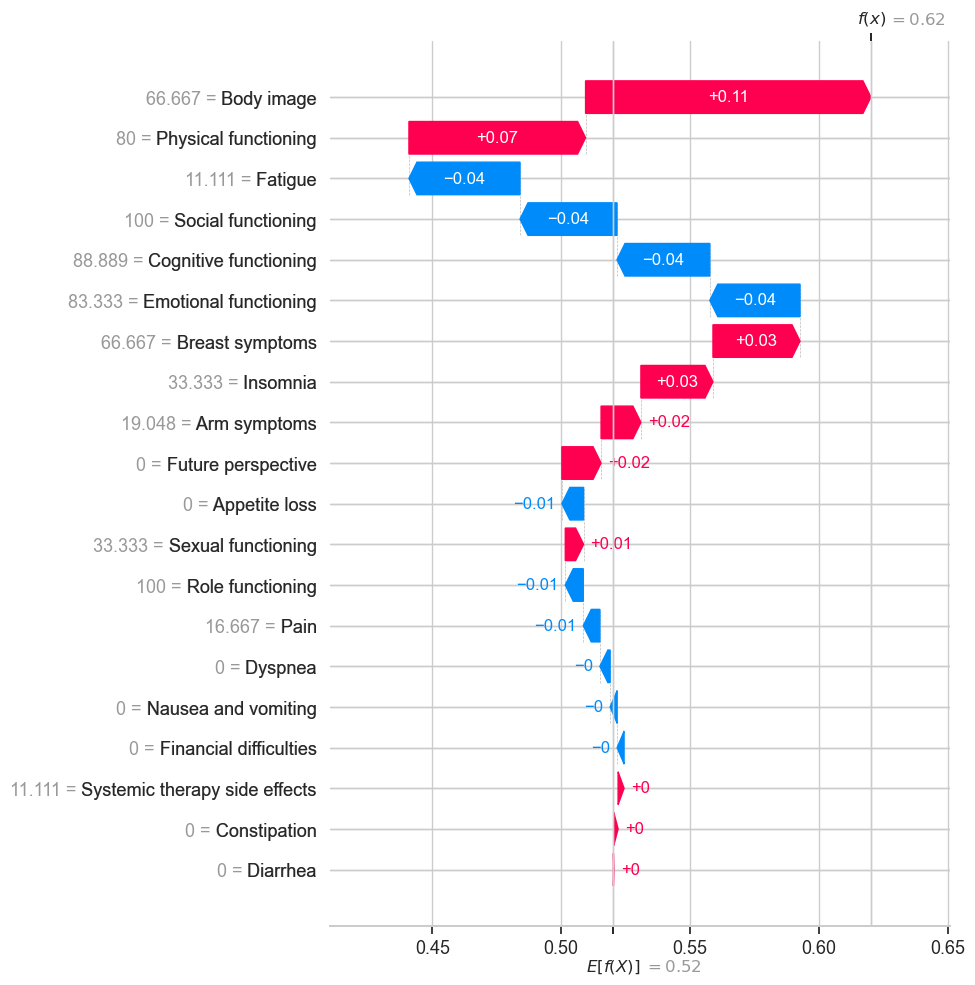

In [28]:
shap.plots.waterfall(shap_values[:,:,1][tp_low.name], max_display=20)

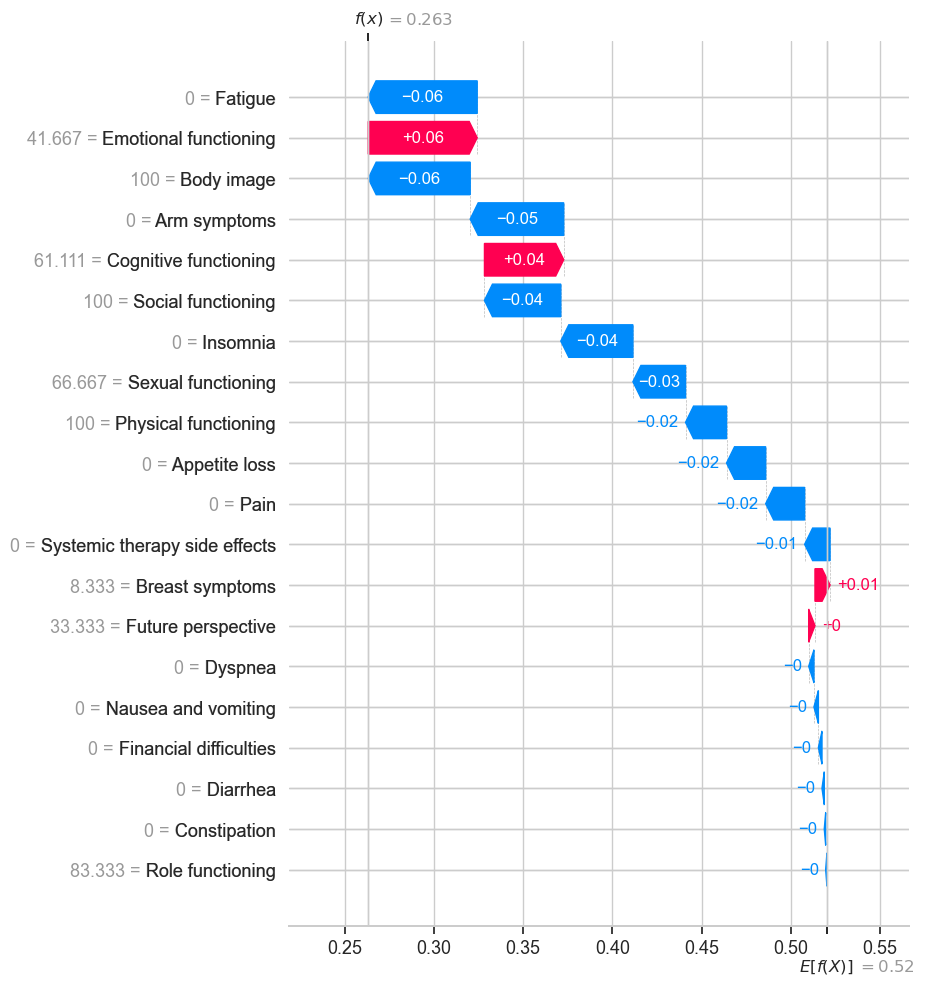

In [29]:
shap.plots.waterfall(shap_values[:,:,1][fn_high.name], max_display=20)

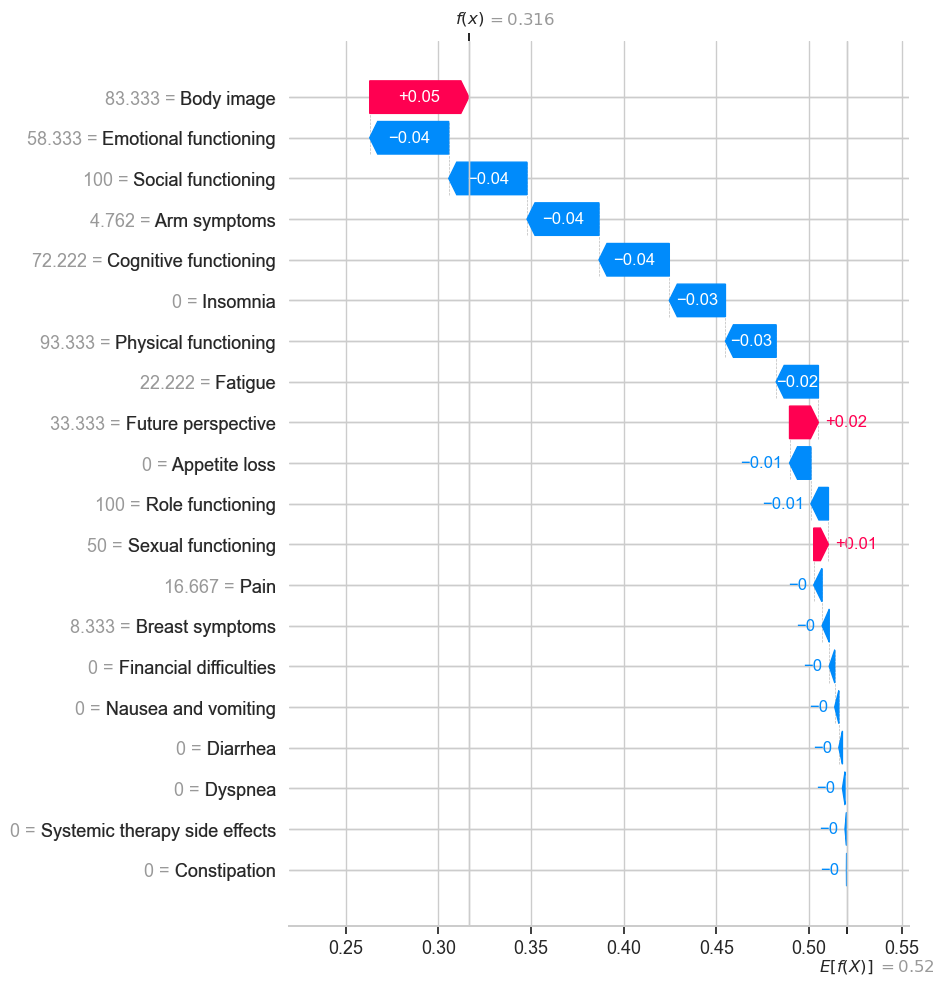

In [30]:
shap.plots.waterfall(shap_values[:,:,1][fn_low.name], max_display=20)

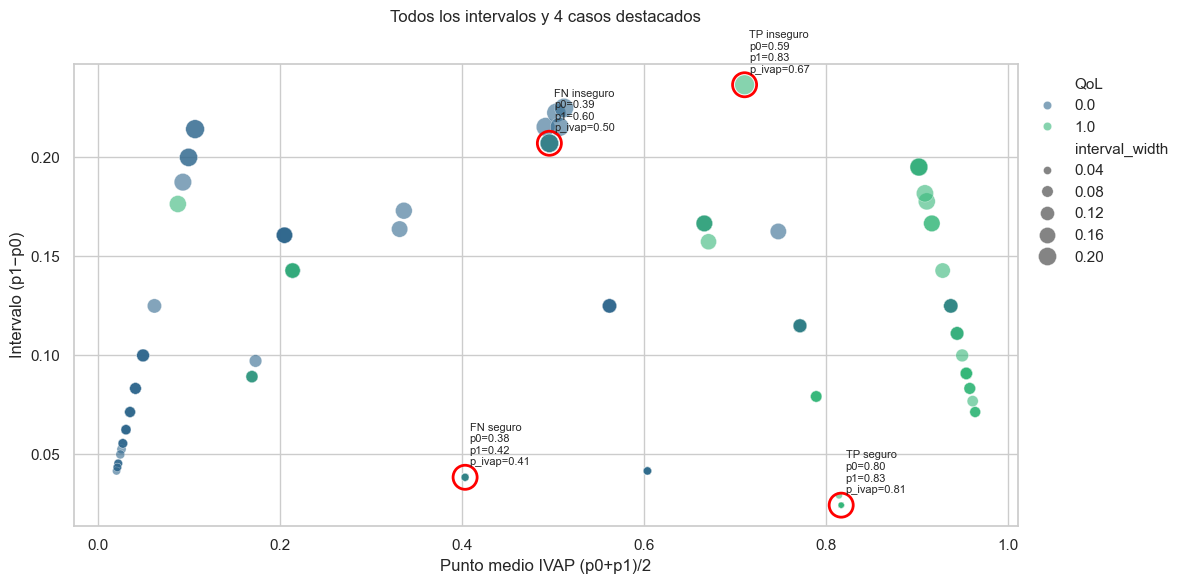

In [31]:
# Todos los puntos: x=p_mid, y=interval_width, color por QoL y tamaño por interval_width
plt.figure(figsize=(12,6))
base = sns.scatterplot(
    data=h_prob_va_df,
    x='p_mid', y='interval_width',
    hue='QoL', palette='viridis',
    size='interval_width', sizes=(20,200),
    alpha=0.6, legend='brief'
)

# Destacamos los cuatro casos con un círculo rojo y etiqueta
highlight = [tp_high, tp_low, fn_high, fn_low]
labels    = ['TP seguro','TP inseguro','FN seguro','FN inseguro']

for row, lbl in zip(highlight, labels):
    plt.scatter(
        row['p_mid'], row['interval_width'],
        s=300, facecolors='none', edgecolors='red', linewidths=2
    )
    plt.text(
        row['p_mid']+0.005, row['interval_width']+0.005,
        f"{lbl}\np0={row['p0']:.2f}\np1={row['p1']:.2f}\np_ivap={row['p_ivap']:.2f}",
        fontsize=8, va='bottom'
    )

plt.xlabel('Punto medio IVAP (p0+p1)/2')
plt.ylabel('Intervalo (p1−p0)')
plt.title('Todos los intervalos y 4 casos destacados', pad=30)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

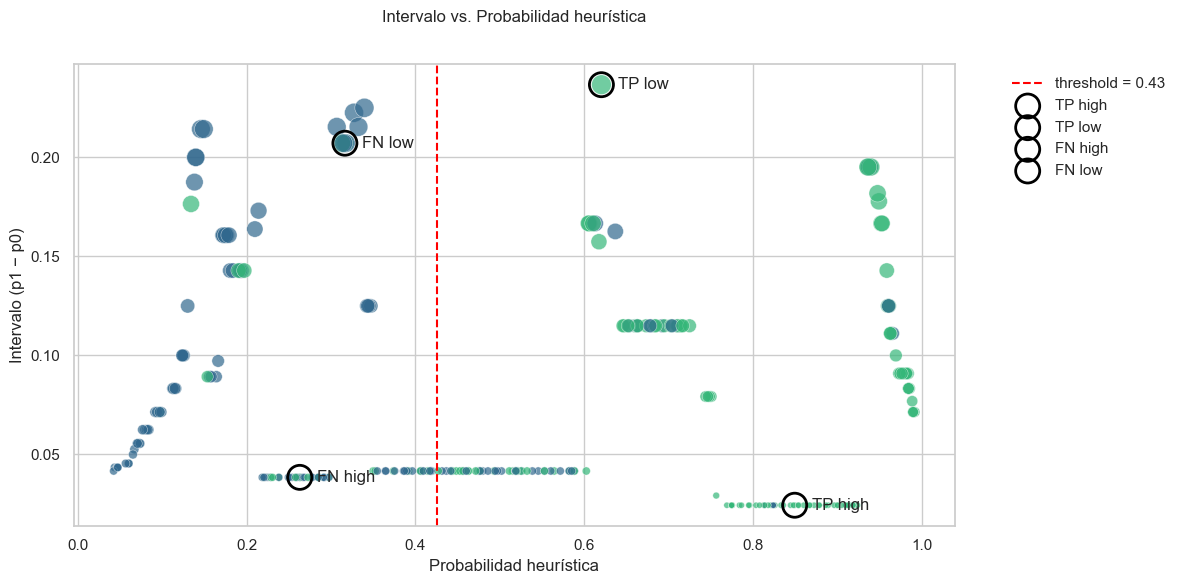

In [32]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='h_prob',
    y='interval_width',
    hue='QoL',
    size='interval_width',
    sizes=(20, 200),
    palette='viridis',
    data=h_prob_va_df,
    alpha=0.7,
    legend=False
)
plt.axvline(threshold, ls='--', color='red', label=f'threshold = {threshold:.2f}')

for case, label in [(tp_high, 'TP high'), (tp_low, 'TP low'), (fn_high, 'FN high'), (fn_low, 'FN low')]:
    plt.scatter(
        case['h_prob'],
        case['interval_width'],
        s=300,
        facecolors='none',
        edgecolors='black',
        linewidth=2,
        label=label
    )
    plt.text(
        case['h_prob'] + 0.02,
        case['interval_width'],
        label,
        va='center'
    )

plt.xlabel('Probabilidad heurística')
plt.ylabel('Intervalo (p1 − p0)')
plt.title('Intervalo vs. Probabilidad heurística', pad=30)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [33]:
emissions: float = tracker.stop()        # devuelve kg CO₂e
print(f"💡 Emisiones estimadas: {emissions:.3f} kg CO₂e")

[codecarbon INFO @ 12:54:21] Energy consumed for RAM : 0.000009 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 12:54:21] Delta energy consumed for CPU with constant : 0.000066 kWh, power : 42.5 W
[codecarbon INFO @ 12:54:21] Energy consumed for All CPU : 0.000066 kWh
[codecarbon INFO @ 12:54:21] 0.000075 kWh of electricity used since the beginning.


💡 Emisiones estimadas: 0.000 kg CO₂e
